# Milestone 2

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scripts import *

### I. Data Prepration

In [2]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader(data_path)


In [3]:
num_classes = len(os.listdir(data_path))
num_classes

5

In [4]:
len(images)

2351

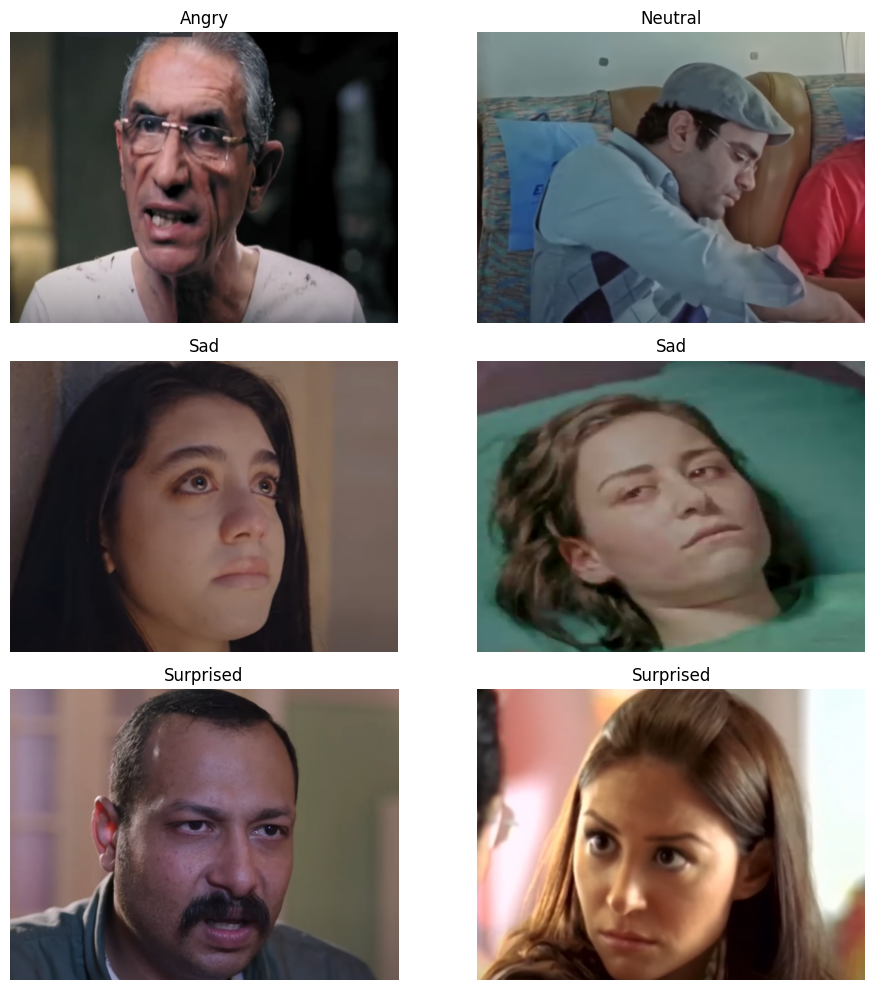

In [5]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator((images, labels))

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645, 512, 512, 3),
 (1645,),
 (470, 512, 512, 3),
 (470,),
 (236, 512, 512, 3),
 (236,))

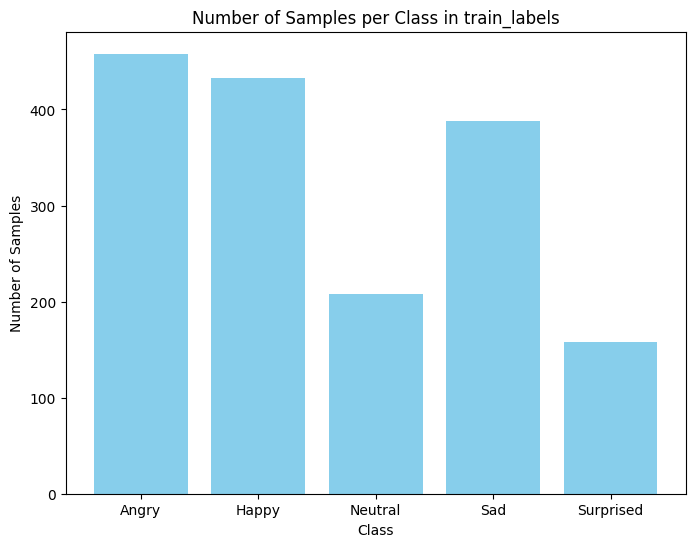

In [7]:
draw_barchart_labels(train_labels, label_to_index)

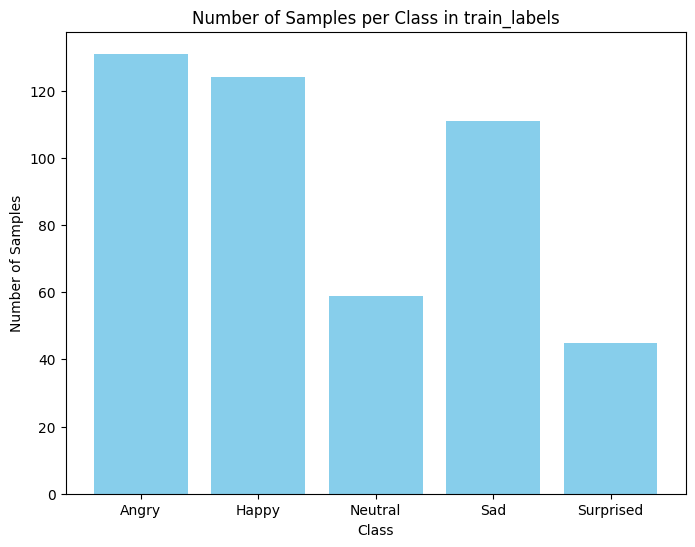

In [8]:
draw_barchart_labels(val_labels, label_to_index)

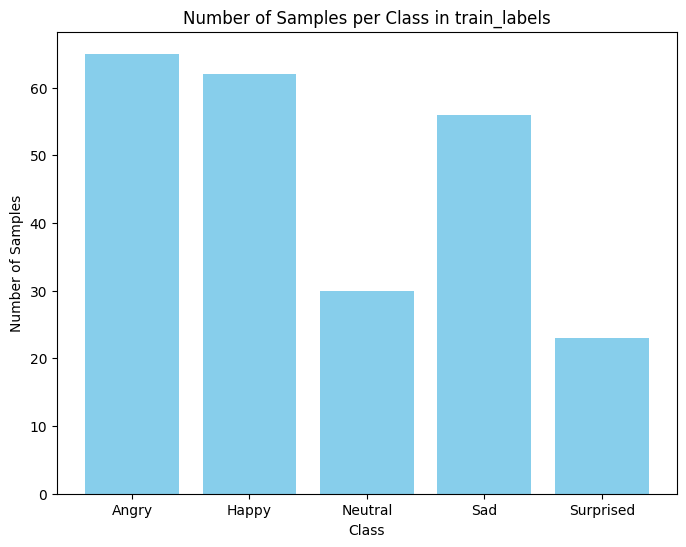

In [9]:
draw_barchart_labels(test_labels, label_to_index)

### II.First Model

In [10]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

In [11]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(train_data[0])
output.shape

(510, 510, 4)

In [12]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters)

output = conv_layer.forward(train_data[0])
output.shape

(510, 510, 5)

In [13]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(train_data[0])
output.shape

(256, 256, 3)

In [14]:
first_model = FirstModel()
first_model.fit(train_data[:20], num_clusters=5)

100%|██████████| 20/20 [03:19<00:00,  9.97s/it]

Extracted features shape: (20, 128)


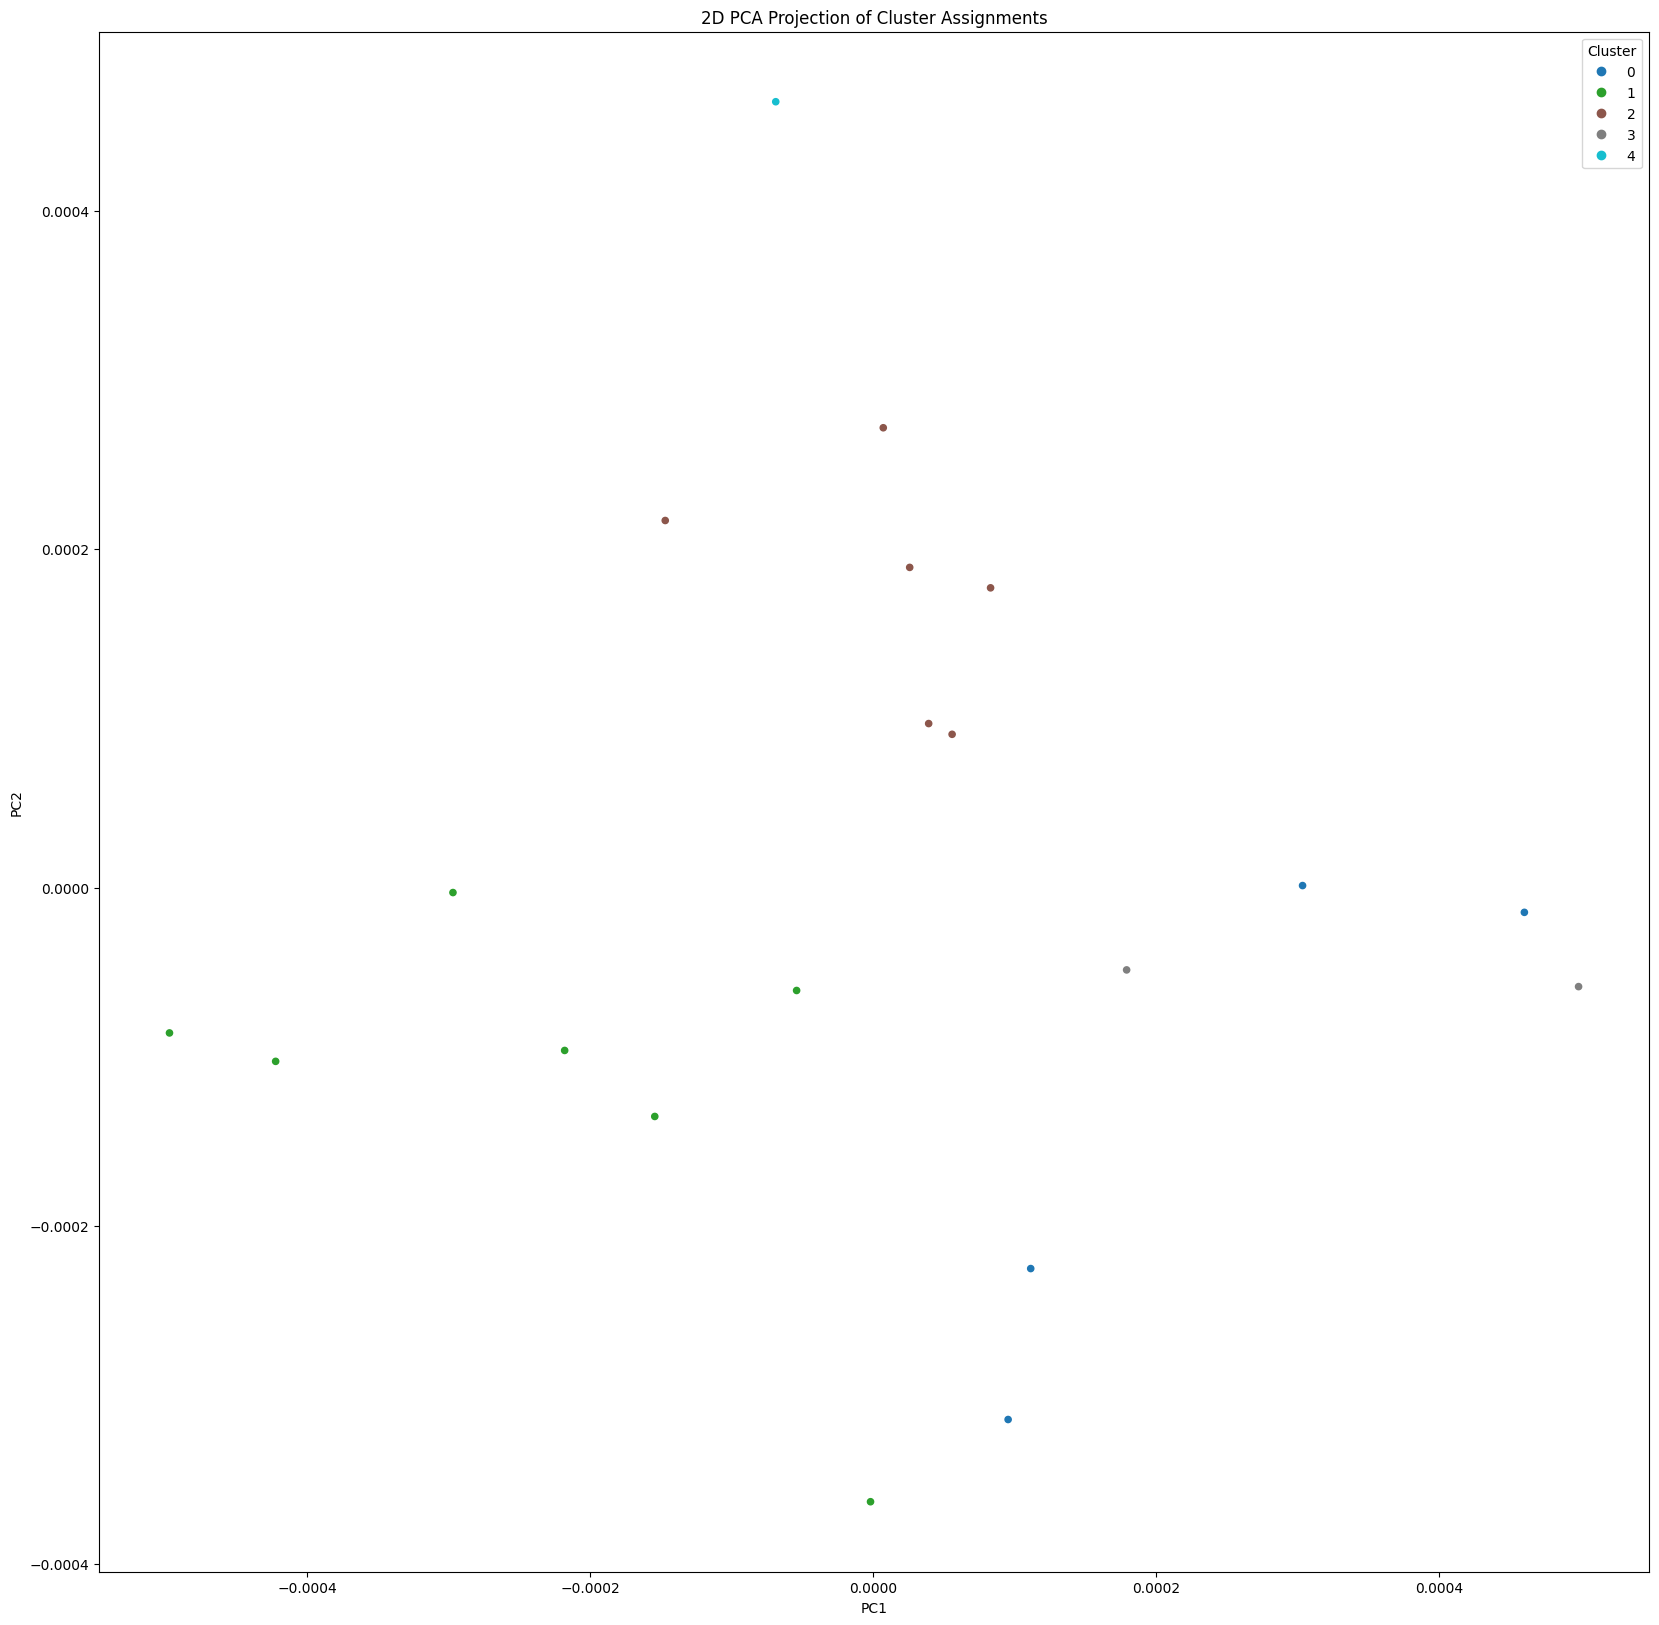

In [15]:
plot_feature_scatter(first_model.features,
                     first_model.kmeans.labels_, n_components=2)

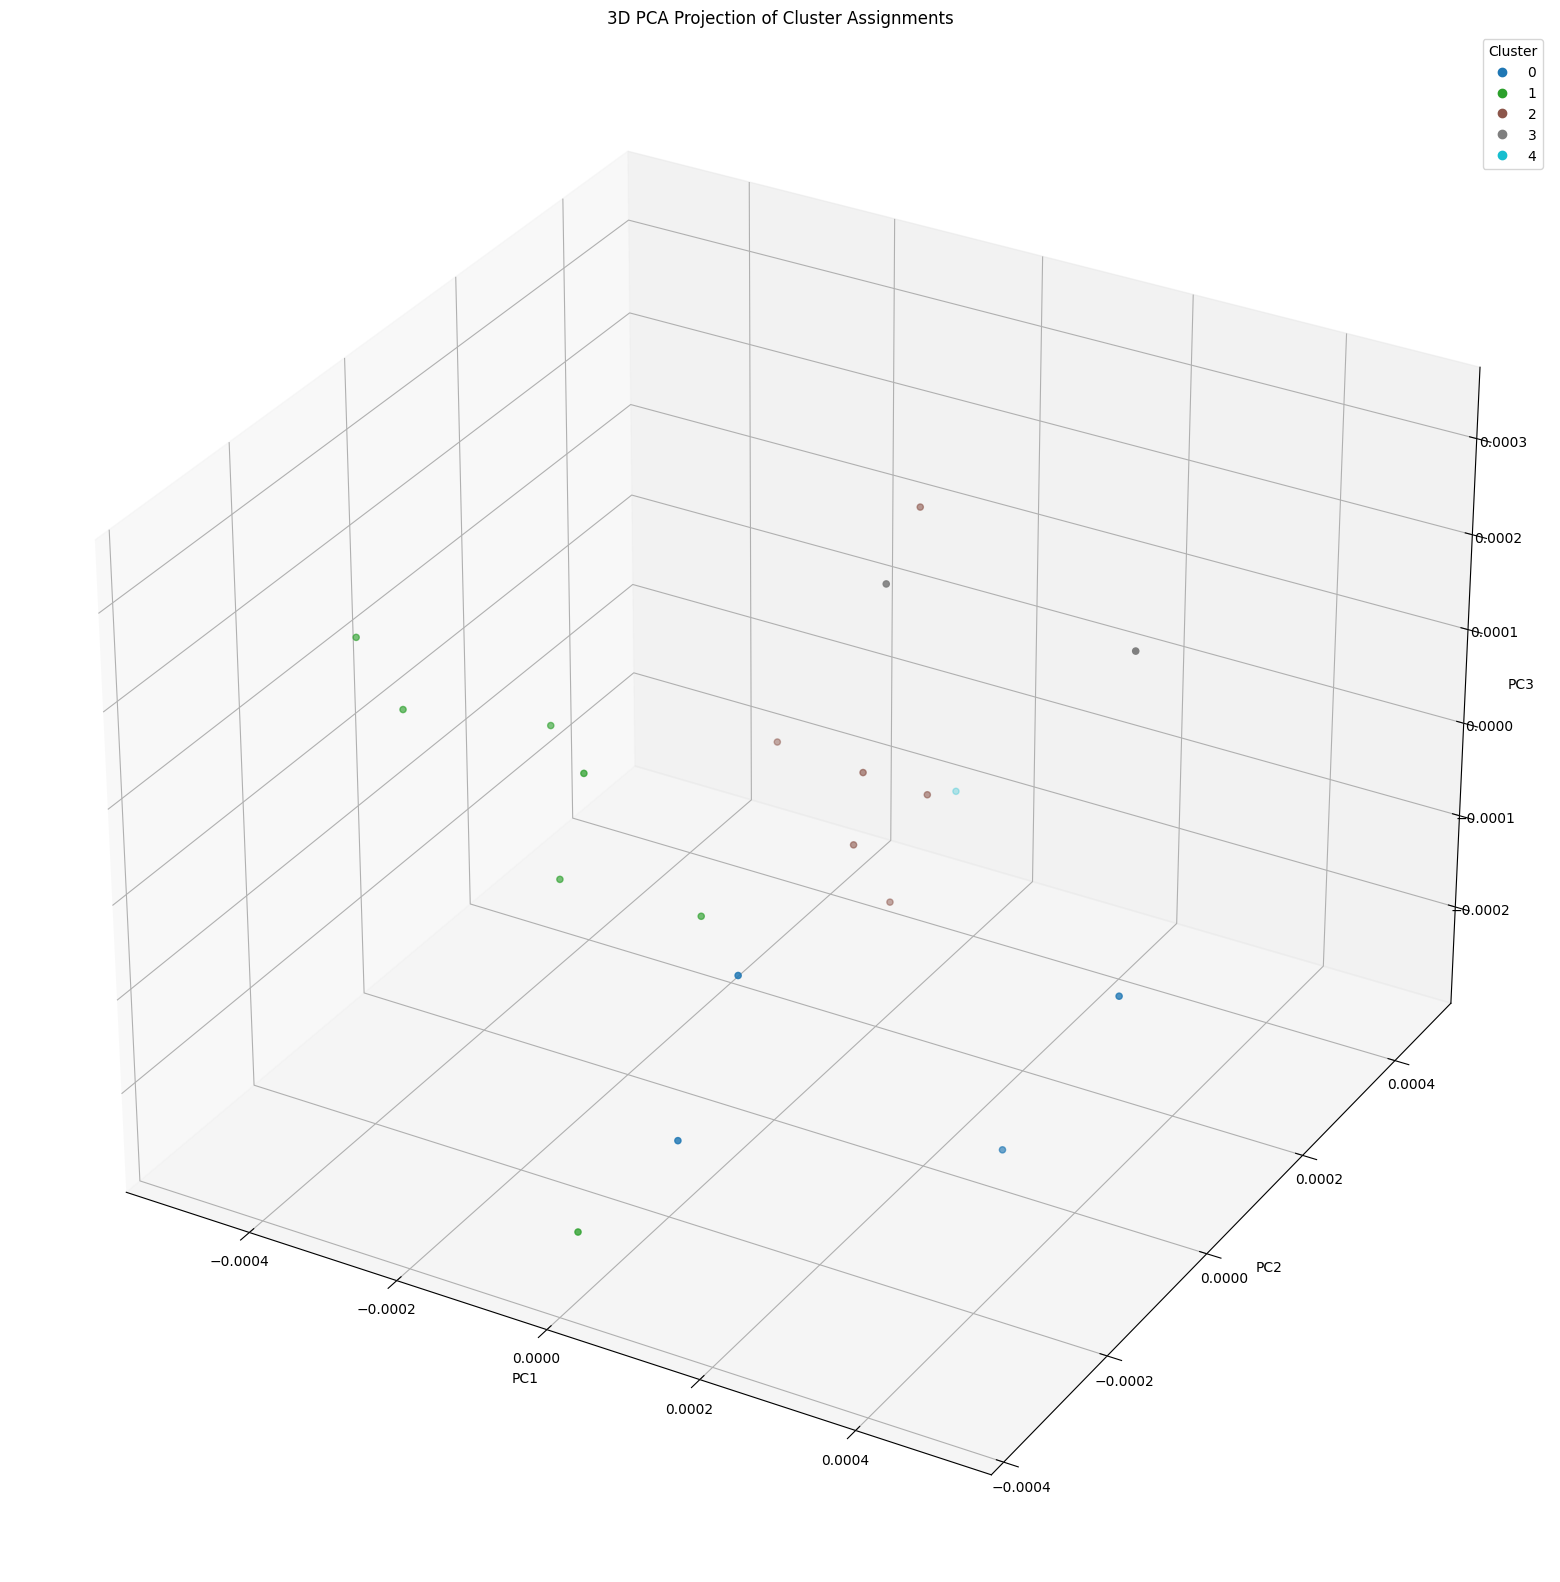

In [16]:
plot_feature_scatter(first_model.features,
                     first_model.kmeans.labels_, n_components=3)

### III. Second Model

In [7]:
train_loader = convert_to_dataloader(data=(train_data, train_labels), batch_size=32)
val_loader = convert_to_dataloader(data=(val_data, val_labels), batch_size=32)
test_loader = convert_to_dataloader(data=(test_data, test_labels), batch_size=32)

In [8]:
# Test second_model is working
second_model = SecondModel()

example_image = torch.tensor(train_data[0], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

output = second_model(example_image)

print("Output shape:", output.shape)
print("Output:", output)

Output shape: torch.Size([1, 5])
Output: tensor([[ 0.1416, -0.3204,  0.0073, -0.4208,  0.0667]],
       grad_fn=<AddmmBackward0>)


In [9]:
model = SecondModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 20

train_losses, val_losses, train_accuracies, val_accuracies = training(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/20]
train_loss: 0.0477, train_acc: 0.3325


val_Loss: 1.5463, val_Accuracy: 0.3128, val_Precision: 0.2204, val_Recall: 0.2531, val_F1: 0.1931
--------------------------------------------------


Epoch [2/20]
train_loss: 0.0443, train_acc: 0.3988


val_Loss: 1.4076, val_Accuracy: 0.3979, val_Precision: 0.2467, val_Recall: 0.3027, val_F1: 0.2661
--------------------------------------------------


Epoch [3/20]
train_loss: 0.0420, train_acc: 0.4511


val_Loss: 1.3923, val_Accuracy: 0.3787, val_Precision: 0.3091, val_Recall: 0.3017, val_F1: 0.2720
--------------------------------------------------


Epoch [4/20]
train_loss: 0.0397, train_acc: 0.4857


val_Loss: 1.4339, val_Accuracy: 0.3851, val_Precision: 0.2891, val_Recall: 0.3058, val_F1: 0.2820
--------------------------------------------------


Epoch [5/20]
train_loss: 0.0373, train_acc: 0.5264


val_Loss: 1.3412, val_Accuracy: 0.4234, val_Precision: 0.3785, val_Recall: 0.3393, val_F1: 0.3249
--------------------------------------------------


Epoch [6/20]
train_loss: 0.0343, train_acc: 0.5793


val_Loss: 1.3625, val_Accuracy: 0.4340, val_Precision: 0.4376, val_Recall: 0.3684, val_F1: 0.3535
--------------------------------------------------


Epoch [7/20]
train_loss: 0.0309, train_acc: 0.6261


val_Loss: 1.2828, val_Accuracy: 0.4745, val_Precision: 0.5144, val_Recall: 0.3892, val_F1: 0.3897
--------------------------------------------------


Epoch [8/20]
train_loss: 0.0288, train_acc: 0.6620


val_Loss: 1.3075, val_Accuracy: 0.4596, val_Precision: 0.4516, val_Recall: 0.3799, val_F1: 0.3772
--------------------------------------------------


Epoch [9/20]
train_loss: 0.0253, train_acc: 0.7234


val_Loss: 1.3022, val_Accuracy: 0.4638, val_Precision: 0.4332, val_Recall: 0.4073, val_F1: 0.4125
--------------------------------------------------


Epoch [10/20]
train_loss: 0.0226, train_acc: 0.7678


val_Loss: 1.3105, val_Accuracy: 0.4787, val_Precision: 0.4462, val_Recall: 0.4137, val_F1: 0.4177
--------------------------------------------------


Epoch [11/20]
train_loss: 0.0192, train_acc: 0.8116


val_Loss: 1.2895, val_Accuracy: 0.4660, val_Precision: 0.4314, val_Recall: 0.4129, val_F1: 0.4173
--------------------------------------------------


Epoch [12/20]
train_loss: 0.0160, train_acc: 0.8681


val_Loss: 1.2695, val_Accuracy: 0.5106, val_Precision: 0.4715, val_Recall: 0.4527, val_F1: 0.4574
--------------------------------------------------


Epoch [13/20]
train_loss: 0.0132, train_acc: 0.9021


val_Loss: 1.3471, val_Accuracy: 0.4745, val_Precision: 0.4286, val_Recall: 0.4185, val_F1: 0.4180
--------------------------------------------------


Epoch [14/20]
train_loss: 0.0109, train_acc: 0.9301


val_Loss: 1.3516, val_Accuracy: 0.4957, val_Precision: 0.4569, val_Recall: 0.4464, val_F1: 0.4485
--------------------------------------------------


Epoch [15/20]
train_loss: 0.0082, train_acc: 0.9629


val_Loss: 1.4262, val_Accuracy: 0.4809, val_Precision: 0.4435, val_Recall: 0.4191, val_F1: 0.4245
--------------------------------------------------


Epoch [16/20]
train_loss: 0.0063, train_acc: 0.9720


val_Loss: 1.4197, val_Accuracy: 0.4936, val_Precision: 0.4486, val_Recall: 0.4347, val_F1: 0.4365
--------------------------------------------------


Epoch [17/20]
train_loss: 0.0045, train_acc: 0.9860


val_Loss: 1.4442, val_Accuracy: 0.4936, val_Precision: 0.4465, val_Recall: 0.4355, val_F1: 0.4377
--------------------------------------------------


Epoch [18/20]
train_loss: 0.0034, train_acc: 0.9903


val_Loss: 1.4988, val_Accuracy: 0.5213, val_Precision: 0.4809, val_Recall: 0.4556, val_F1: 0.4596
--------------------------------------------------


Epoch [19/20]
train_loss: 0.0025, train_acc: 0.9964


val_Loss: 1.4962, val_Accuracy: 0.5000, val_Precision: 0.4496, val_Recall: 0.4361, val_F1: 0.4380
--------------------------------------------------


Epoch [20/20]
train_loss: 0.0020, train_acc: 0.9982


val_Loss: 1.5558, val_Accuracy: 0.5021, val_Precision: 0.4659, val_Recall: 0.4427, val_F1: 0.4470
--------------------------------------------------


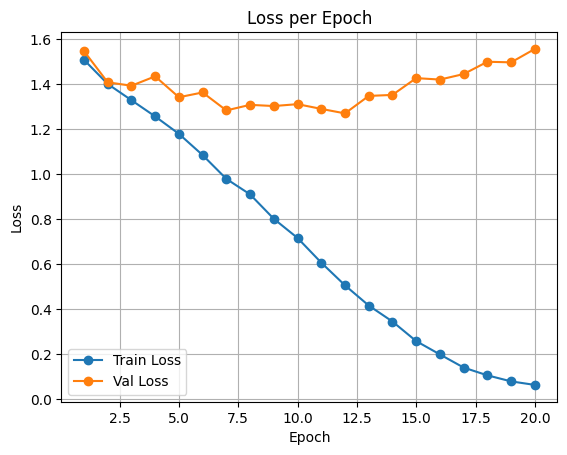

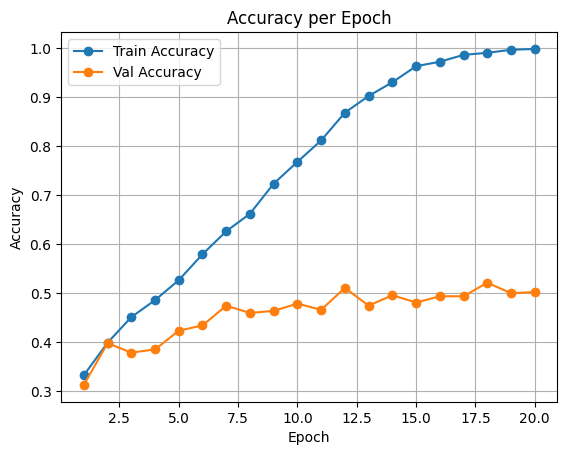

In [10]:
plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

In [11]:
test_metrics = evaluate(model, test_loader, criterion, prefix='test_')

test_Loss: 1.5170, test_Accuracy: 0.4661, test_Precision: 0.4088, test_Recall: 0.4146, test_F1: 0.4091


#### Using augmentation

In [12]:
# train_loader_augmented = convert_to_dataloader(data=(train_data, train_labels), batch_size=32, use_aug=True)

# index_to_label = {v: k for k, v in label_to_index.items()}
# i = 0
# for im, label in train_loader_augmented:
#     print(im.shape, label.shape)
#     # Display the first image and its label
#     plt.imshow(im[0].permute(1, 2, 0).numpy())
#     plt.title(index_to_label[label[0].item()])
#     plt.axis('off')
#     plt.show()
#     if i==10:
#         break
#     i+=1

In [13]:
train_loader_augmented = convert_to_dataloader_optimized(data=(train_data, train_labels), batch_size=32, use_aug=True)

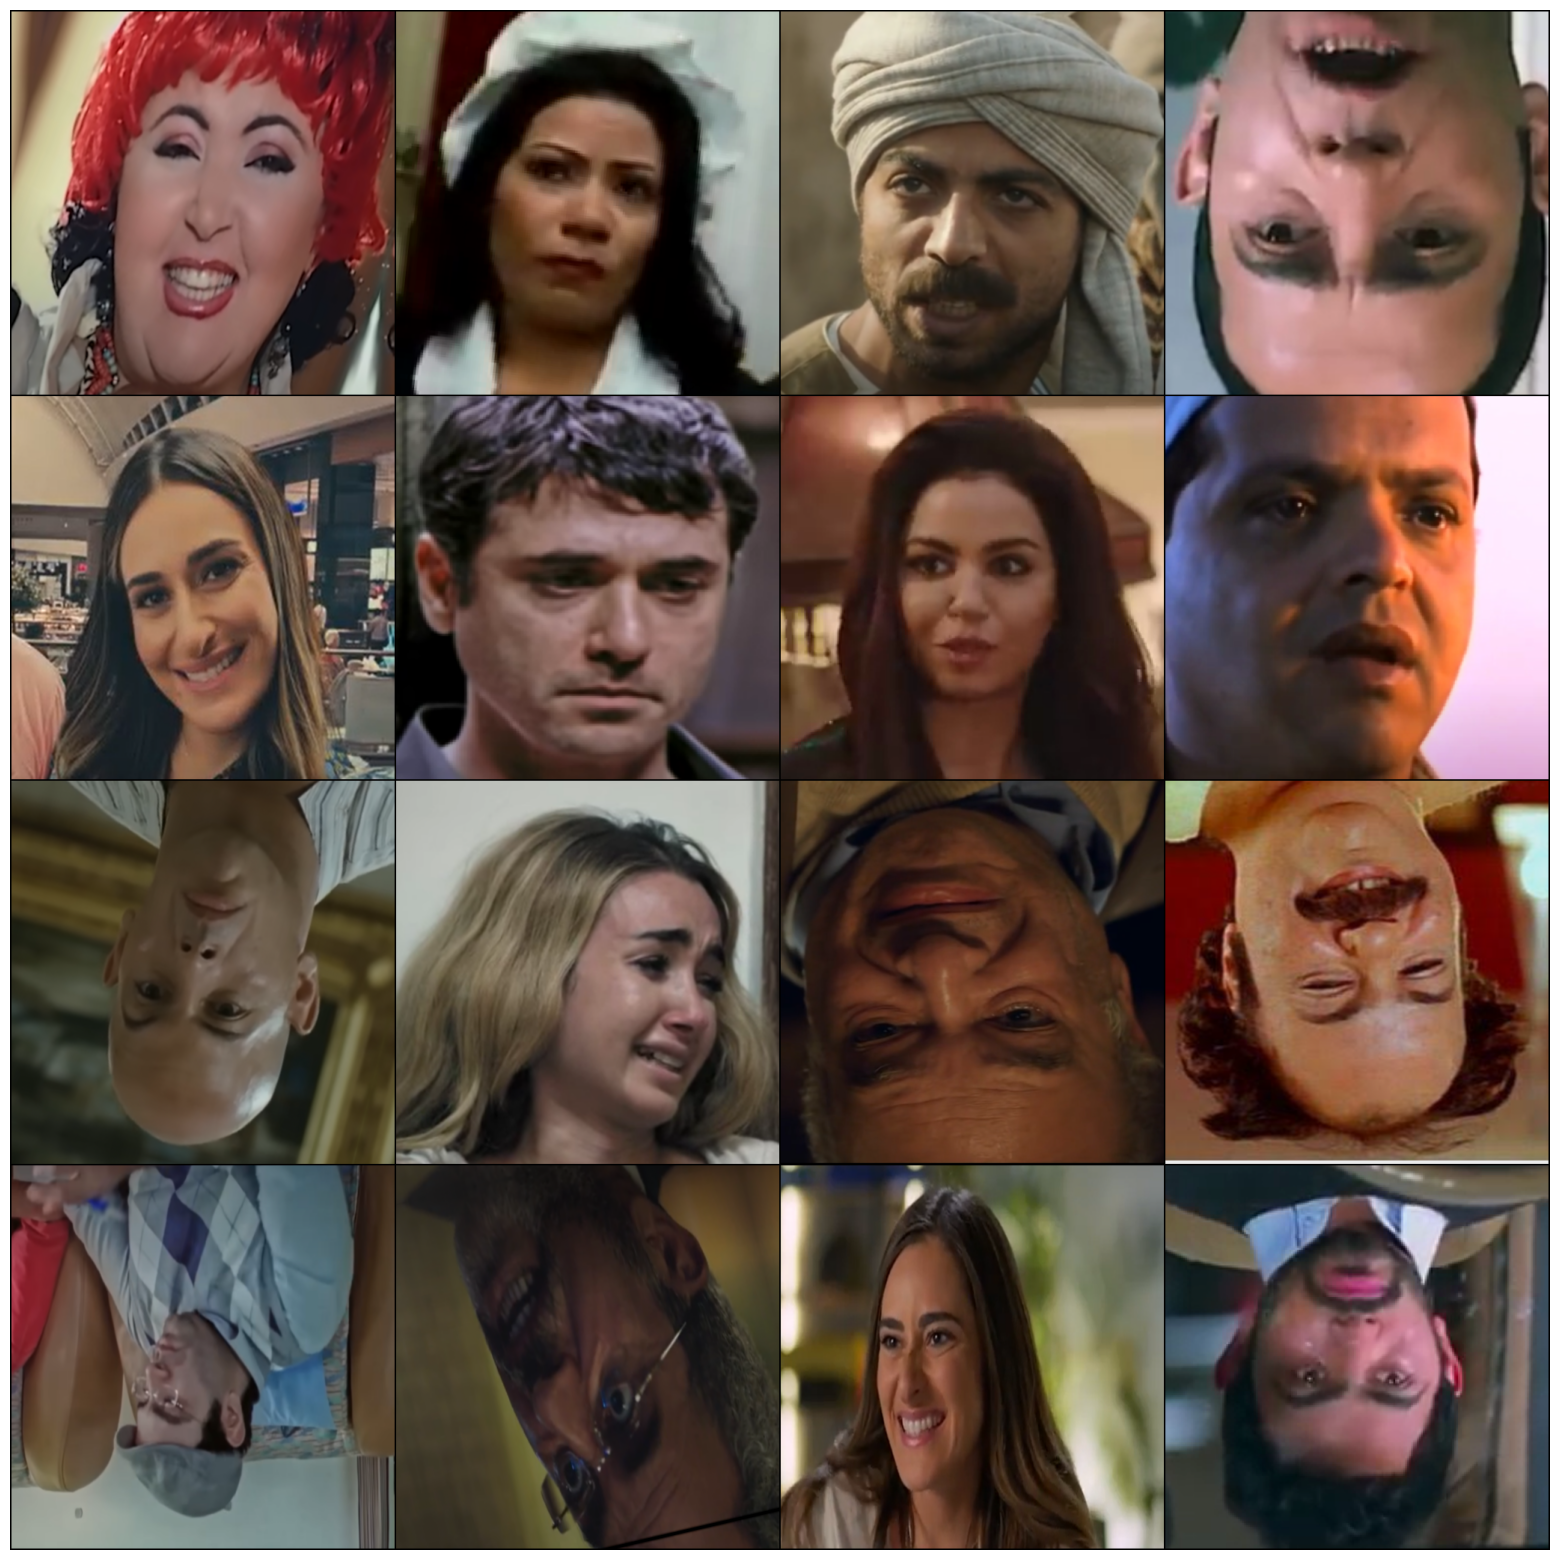

In [14]:
from torchvision.utils import make_grid

images, labels = next(iter(train_loader_augmented))  # shape: [16, 3, 512, 512]

grid = make_grid(images[:16], nrow=4, padding=2)     # → [3, Hg, Wg]

grid_np = grid.permute(1, 2, 0).cpu().numpy()        # → (Hg, Wg, 3)
plt.figure(figsize=(20,20))
plt.imshow(grid_np)
plt.axis('off')
plt.show()


In [15]:
model = SecondModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

train_losses, val_losses, train_accuracies, val_accuracies = training(model, train_loader_augmented, val_loader, criterion, optimizer, num_epochs)

Epoch [1/20]
train_loss: 0.0481, train_acc: 0.3179


val_Loss: 1.5304, val_Accuracy: 0.3000, val_Precision: 0.2194, val_Recall: 0.2399, val_F1: 0.2080
--------------------------------------------------


Epoch [2/20]
train_loss: 0.0468, train_acc: 0.3435


val_Loss: 1.4886, val_Accuracy: 0.3596, val_Precision: 0.2971, val_Recall: 0.3080, val_F1: 0.2910
--------------------------------------------------


Epoch [3/20]
train_loss: 0.0460, train_acc: 0.3544


val_Loss: 1.4537, val_Accuracy: 0.3723, val_Precision: 0.2887, val_Recall: 0.3035, val_F1: 0.2902
--------------------------------------------------


Epoch [4/20]
train_loss: 0.0452, train_acc: 0.3672


val_Loss: 1.4851, val_Accuracy: 0.3362, val_Precision: 0.2915, val_Recall: 0.2841, val_F1: 0.2552
--------------------------------------------------


Epoch [5/20]
train_loss: 0.0449, train_acc: 0.3866


val_Loss: 1.4505, val_Accuracy: 0.3489, val_Precision: 0.2738, val_Recall: 0.2738, val_F1: 0.2498
--------------------------------------------------


Epoch [6/20]
train_loss: 0.0442, train_acc: 0.4152


val_Loss: 1.4067, val_Accuracy: 0.4106, val_Precision: 0.3503, val_Recall: 0.3347, val_F1: 0.3201
--------------------------------------------------


Epoch [7/20]
train_loss: 0.0432, train_acc: 0.4377


val_Loss: 1.4539, val_Accuracy: 0.3702, val_Precision: 0.3030, val_Recall: 0.3201, val_F1: 0.2992
--------------------------------------------------


Epoch [8/20]
train_loss: 0.0430, train_acc: 0.4243


val_Loss: 1.4132, val_Accuracy: 0.3745, val_Precision: 0.2752, val_Recall: 0.2926, val_F1: 0.2710
--------------------------------------------------


Epoch [9/20]
train_loss: 0.0423, train_acc: 0.4334


val_Loss: 1.4065, val_Accuracy: 0.4000, val_Precision: 0.3134, val_Recall: 0.3216, val_F1: 0.3022
--------------------------------------------------


Epoch [10/20]
train_loss: 0.0413, train_acc: 0.4559


val_Loss: 1.4278, val_Accuracy: 0.3787, val_Precision: 0.2918, val_Recall: 0.3060, val_F1: 0.2893
--------------------------------------------------


Epoch [11/20]
train_loss: 0.0412, train_acc: 0.4450


val_Loss: 1.3905, val_Accuracy: 0.3979, val_Precision: 0.3176, val_Recall: 0.3355, val_F1: 0.3220
--------------------------------------------------


Epoch [12/20]
train_loss: 0.0403, train_acc: 0.4638


val_Loss: 1.3729, val_Accuracy: 0.4128, val_Precision: 0.3223, val_Recall: 0.3435, val_F1: 0.3294
--------------------------------------------------


Epoch [13/20]
train_loss: 0.0404, train_acc: 0.4584


val_Loss: 1.3823, val_Accuracy: 0.3872, val_Precision: 0.3223, val_Recall: 0.3459, val_F1: 0.3212
--------------------------------------------------


Epoch [14/20]
train_loss: 0.0402, train_acc: 0.4784


val_Loss: 1.3827, val_Accuracy: 0.3957, val_Precision: 0.3049, val_Recall: 0.3181, val_F1: 0.3024
--------------------------------------------------


Epoch [15/20]
train_loss: 0.0395, train_acc: 0.4875


val_Loss: 1.3759, val_Accuracy: 0.3872, val_Precision: 0.3231, val_Recall: 0.3308, val_F1: 0.3157
--------------------------------------------------


Epoch [16/20]
train_loss: 0.0385, train_acc: 0.5082


val_Loss: 1.3642, val_Accuracy: 0.3979, val_Precision: 0.4772, val_Recall: 0.3625, val_F1: 0.3445
--------------------------------------------------


Epoch [17/20]
train_loss: 0.0381, train_acc: 0.5088


val_Loss: 1.3747, val_Accuracy: 0.4128, val_Precision: 0.4394, val_Recall: 0.3411, val_F1: 0.3365
--------------------------------------------------


Epoch [18/20]
train_loss: 0.0372, train_acc: 0.5125


val_Loss: 1.3328, val_Accuracy: 0.4319, val_Precision: 0.3866, val_Recall: 0.3635, val_F1: 0.3582
--------------------------------------------------


Epoch [19/20]
train_loss: 0.0367, train_acc: 0.5277


val_Loss: 1.3173, val_Accuracy: 0.4362, val_Precision: 0.4117, val_Recall: 0.3676, val_F1: 0.3588
--------------------------------------------------


Epoch [20/20]
train_loss: 0.0363, train_acc: 0.5343


val_Loss: 1.3683, val_Accuracy: 0.4000, val_Precision: 0.3692, val_Recall: 0.3229, val_F1: 0.3119
--------------------------------------------------


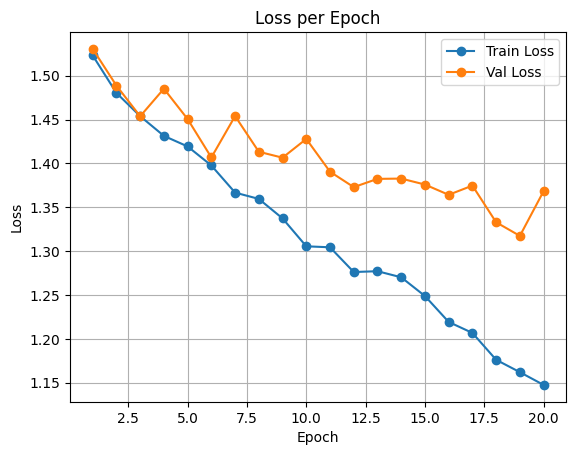

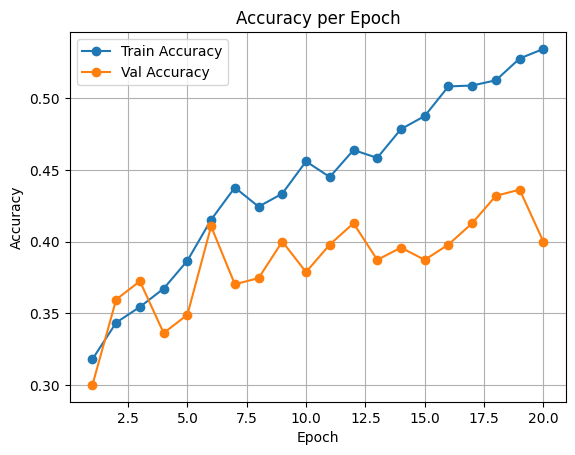

In [16]:
plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

In [17]:
test_metrics = evaluate(model, test_loader, criterion, prefix='test_')

test_Loss: 1.2890, test_Accuracy: 0.4703, test_Precision: 0.4815, test_Recall: 0.3924, test_F1: 0.3960


### Pretrained Model

#### ResNet18

In [18]:
import torchvision.models as models
from torch import nn
from torchvision import transforms

model = get_pretrained_model(model_name="resnet18", num_classes=5)

# Resize and normalize the images for pretrained models like ResNet
transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_loader_pretrained = convert_to_dataloader(data=(train_data, train_labels), batch_size=32, transform=transform)
val_loader_pretrained = convert_to_dataloader(data=(val_data, val_labels), batch_size=32, transform=transform)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = training(model, train_loader_pretrained, val_loader_pretrained, criterion, optimizer, num_epochs)



c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50]
train_loss: 0.0478, train_acc: 0.3544


val_Loss: 1.4359, val_Accuracy: 0.3872, val_Precision: 0.3252, val_Recall: 0.2980, val_F1: 0.2717
--------------------------------------------------


Epoch [2/50]
train_loss: 0.0418, train_acc: 0.4371


val_Loss: 1.3895, val_Accuracy: 0.3915, val_Precision: 0.3271, val_Recall: 0.3265, val_F1: 0.3153
--------------------------------------------------


Epoch [3/50]
train_loss: 0.0396, train_acc: 0.5052


val_Loss: 1.3601, val_Accuracy: 0.4149, val_Precision: 0.3933, val_Recall: 0.3477, val_F1: 0.3405
--------------------------------------------------


Epoch [4/50]
train_loss: 0.0364, train_acc: 0.5350


val_Loss: 1.3163, val_Accuracy: 0.4426, val_Precision: 0.4426, val_Recall: 0.3591, val_F1: 0.3492
--------------------------------------------------


Epoch [5/50]
train_loss: 0.0355, train_acc: 0.5581


val_Loss: 1.3248, val_Accuracy: 0.4277, val_Precision: 0.4356, val_Recall: 0.3405, val_F1: 0.3271
--------------------------------------------------


Epoch [6/50]
train_loss: 0.0349, train_acc: 0.5544


val_Loss: 1.3029, val_Accuracy: 0.4511, val_Precision: 0.4435, val_Recall: 0.3704, val_F1: 0.3651
--------------------------------------------------


Epoch [7/50]
train_loss: 0.0335, train_acc: 0.5733


val_Loss: 1.3145, val_Accuracy: 0.4660, val_Precision: 0.4716, val_Recall: 0.3840, val_F1: 0.3801
--------------------------------------------------


Epoch [8/50]
train_loss: 0.0333, train_acc: 0.5854


val_Loss: 1.3014, val_Accuracy: 0.4787, val_Precision: 0.4622, val_Recall: 0.4188, val_F1: 0.4196
--------------------------------------------------


Epoch [9/50]
train_loss: 0.0322, train_acc: 0.6097


val_Loss: 1.3031, val_Accuracy: 0.4596, val_Precision: 0.4392, val_Recall: 0.4261, val_F1: 0.4284
--------------------------------------------------


Epoch [10/50]
train_loss: 0.0320, train_acc: 0.6103


val_Loss: 1.2980, val_Accuracy: 0.4809, val_Precision: 0.4587, val_Recall: 0.4009, val_F1: 0.3987
--------------------------------------------------


Epoch [11/50]
train_loss: 0.0312, train_acc: 0.6201


val_Loss: 1.3084, val_Accuracy: 0.4638, val_Precision: 0.4473, val_Recall: 0.3978, val_F1: 0.4004
--------------------------------------------------


Epoch [12/50]
train_loss: 0.0306, train_acc: 0.6347


val_Loss: 1.3435, val_Accuracy: 0.4702, val_Precision: 0.4839, val_Recall: 0.4379, val_F1: 0.4214
--------------------------------------------------


Epoch [13/50]
train_loss: 0.0311, train_acc: 0.6134


val_Loss: 1.2992, val_Accuracy: 0.4787, val_Precision: 0.4502, val_Recall: 0.4288, val_F1: 0.4263
--------------------------------------------------


Epoch [14/50]
train_loss: 0.0304, train_acc: 0.6298


val_Loss: 1.3344, val_Accuracy: 0.4617, val_Precision: 0.4588, val_Recall: 0.4157, val_F1: 0.4145
--------------------------------------------------


Epoch [15/50]
train_loss: 0.0297, train_acc: 0.6444


val_Loss: 1.3668, val_Accuracy: 0.4745, val_Precision: 0.5143, val_Recall: 0.4154, val_F1: 0.4161
--------------------------------------------------


Epoch [16/50]
train_loss: 0.0301, train_acc: 0.6267


val_Loss: 1.3612, val_Accuracy: 0.4596, val_Precision: 0.4379, val_Recall: 0.3806, val_F1: 0.3667
--------------------------------------------------


Epoch [17/50]
train_loss: 0.0292, train_acc: 0.6523


val_Loss: 1.3584, val_Accuracy: 0.4766, val_Precision: 0.4923, val_Recall: 0.4457, val_F1: 0.4474
--------------------------------------------------


Epoch [18/50]
train_loss: 0.0288, train_acc: 0.6590


val_Loss: 1.2993, val_Accuracy: 0.4894, val_Precision: 0.4616, val_Recall: 0.4539, val_F1: 0.4496
--------------------------------------------------


Epoch [19/50]
train_loss: 0.0287, train_acc: 0.6736


val_Loss: 1.3205, val_Accuracy: 0.4787, val_Precision: 0.4775, val_Recall: 0.4190, val_F1: 0.4293
--------------------------------------------------


Epoch [20/50]
train_loss: 0.0289, train_acc: 0.6571


val_Loss: 1.3102, val_Accuracy: 0.4915, val_Precision: 0.4883, val_Recall: 0.4295, val_F1: 0.4377
--------------------------------------------------


Epoch [21/50]
train_loss: 0.0286, train_acc: 0.6553


val_Loss: 1.3886, val_Accuracy: 0.4468, val_Precision: 0.4333, val_Recall: 0.4196, val_F1: 0.4033
--------------------------------------------------


Epoch [22/50]
train_loss: 0.0288, train_acc: 0.6456


val_Loss: 1.3164, val_Accuracy: 0.4830, val_Precision: 0.4638, val_Recall: 0.4350, val_F1: 0.4406
--------------------------------------------------


Epoch [23/50]
train_loss: 0.0281, train_acc: 0.6626


val_Loss: 1.3603, val_Accuracy: 0.4915, val_Precision: 0.4875, val_Recall: 0.4613, val_F1: 0.4625
--------------------------------------------------


Epoch [24/50]
train_loss: 0.0273, train_acc: 0.6705


val_Loss: 1.3566, val_Accuracy: 0.4660, val_Precision: 0.4331, val_Recall: 0.4324, val_F1: 0.4217
--------------------------------------------------


Epoch [25/50]
train_loss: 0.0276, train_acc: 0.6614


val_Loss: 1.3171, val_Accuracy: 0.4894, val_Precision: 0.4708, val_Recall: 0.4302, val_F1: 0.4383
--------------------------------------------------


Epoch [26/50]
train_loss: 0.0275, train_acc: 0.6772


val_Loss: 1.3294, val_Accuracy: 0.5043, val_Precision: 0.5302, val_Recall: 0.4407, val_F1: 0.4490
--------------------------------------------------


Epoch [27/50]
train_loss: 0.0273, train_acc: 0.6596


val_Loss: 1.3943, val_Accuracy: 0.4723, val_Precision: 0.5088, val_Recall: 0.4012, val_F1: 0.4031
--------------------------------------------------


Epoch [28/50]
train_loss: 0.0279, train_acc: 0.6614


val_Loss: 1.3450, val_Accuracy: 0.4681, val_Precision: 0.4339, val_Recall: 0.4311, val_F1: 0.4258
--------------------------------------------------


Epoch [29/50]
train_loss: 0.0268, train_acc: 0.6869


val_Loss: 1.3411, val_Accuracy: 0.4809, val_Precision: 0.4686, val_Recall: 0.4422, val_F1: 0.4455
--------------------------------------------------


Epoch [30/50]
train_loss: 0.0267, train_acc: 0.6827


val_Loss: 1.3264, val_Accuracy: 0.4936, val_Precision: 0.4583, val_Recall: 0.4541, val_F1: 0.4503
--------------------------------------------------


Epoch [31/50]
train_loss: 0.0262, train_acc: 0.6954


val_Loss: 1.3416, val_Accuracy: 0.4809, val_Precision: 0.4686, val_Recall: 0.4237, val_F1: 0.4319
--------------------------------------------------


Epoch [32/50]
train_loss: 0.0269, train_acc: 0.6784


val_Loss: 1.3439, val_Accuracy: 0.4979, val_Precision: 0.4851, val_Recall: 0.4508, val_F1: 0.4597
--------------------------------------------------


Epoch [33/50]
train_loss: 0.0266, train_acc: 0.6729


val_Loss: 1.3213, val_Accuracy: 0.4830, val_Precision: 0.4527, val_Recall: 0.4414, val_F1: 0.4448
--------------------------------------------------


Epoch [34/50]
train_loss: 0.0254, train_acc: 0.6954


val_Loss: 1.3462, val_Accuracy: 0.4851, val_Precision: 0.4694, val_Recall: 0.4295, val_F1: 0.4362
--------------------------------------------------


Epoch [35/50]
train_loss: 0.0261, train_acc: 0.6930


val_Loss: 1.3399, val_Accuracy: 0.4915, val_Precision: 0.4687, val_Recall: 0.4428, val_F1: 0.4492
--------------------------------------------------


Epoch [36/50]
train_loss: 0.0261, train_acc: 0.6784


val_Loss: 1.3660, val_Accuracy: 0.4979, val_Precision: 0.4885, val_Recall: 0.4298, val_F1: 0.4366
--------------------------------------------------


Epoch [37/50]
train_loss: 0.0264, train_acc: 0.6657


val_Loss: 1.3564, val_Accuracy: 0.4936, val_Precision: 0.4676, val_Recall: 0.4445, val_F1: 0.4486
--------------------------------------------------


Epoch [38/50]
train_loss: 0.0250, train_acc: 0.7119


val_Loss: 1.3829, val_Accuracy: 0.4851, val_Precision: 0.4841, val_Recall: 0.4251, val_F1: 0.4301
--------------------------------------------------


Epoch [39/50]
train_loss: 0.0253, train_acc: 0.6894


val_Loss: 1.3583, val_Accuracy: 0.4809, val_Precision: 0.4477, val_Recall: 0.4375, val_F1: 0.4401
--------------------------------------------------


Epoch [40/50]
train_loss: 0.0250, train_acc: 0.6979


val_Loss: 1.3648, val_Accuracy: 0.4915, val_Precision: 0.4650, val_Recall: 0.4615, val_F1: 0.4563
--------------------------------------------------


Epoch [41/50]
train_loss: 0.0254, train_acc: 0.7052


val_Loss: 1.3796, val_Accuracy: 0.4915, val_Precision: 0.4691, val_Recall: 0.4469, val_F1: 0.4531


--------------------------------------------------


Epoch [42/50]
train_loss: 0.0257, train_acc: 0.6888


val_Loss: 1.3771, val_Accuracy: 0.4809, val_Precision: 0.4480, val_Recall: 0.4450, val_F1: 0.4411
--------------------------------------------------


Epoch [43/50]
train_loss: 0.0259, train_acc: 0.6881


val_Loss: 1.3753, val_Accuracy: 0.4851, val_Precision: 0.4510, val_Recall: 0.4451, val_F1: 0.4428
--------------------------------------------------


Epoch [44/50]
train_loss: 0.0256, train_acc: 0.6881


val_Loss: 1.3753, val_Accuracy: 0.5021, val_Precision: 0.4810, val_Recall: 0.4792, val_F1: 0.4768
--------------------------------------------------


Epoch [45/50]
train_loss: 0.0250, train_acc: 0.6936


val_Loss: 1.3715, val_Accuracy: 0.4936, val_Precision: 0.4642, val_Recall: 0.4287, val_F1: 0.4334
--------------------------------------------------


Epoch [46/50]
train_loss: 0.0253, train_acc: 0.6888


val_Loss: 1.3771, val_Accuracy: 0.4830, val_Precision: 0.4467, val_Recall: 0.4301, val_F1: 0.4340
--------------------------------------------------


Epoch [47/50]
train_loss: 0.0250, train_acc: 0.6875


val_Loss: 1.3857, val_Accuracy: 0.5085, val_Precision: 0.4933, val_Recall: 0.4449, val_F1: 0.4543
--------------------------------------------------


Epoch [48/50]
train_loss: 0.0254, train_acc: 0.7009


val_Loss: 1.4246, val_Accuracy: 0.4681, val_Precision: 0.4364, val_Recall: 0.4451, val_F1: 0.4301
--------------------------------------------------


Epoch [49/50]
train_loss: 0.0251, train_acc: 0.6857


val_Loss: 1.3915, val_Accuracy: 0.4894, val_Precision: 0.4705, val_Recall: 0.4461, val_F1: 0.4512
--------------------------------------------------


Epoch [50/50]
train_loss: 0.0248, train_acc: 0.7009


val_Loss: 1.3914, val_Accuracy: 0.4915, val_Precision: 0.4659, val_Recall: 0.4377, val_F1: 0.4447
--------------------------------------------------


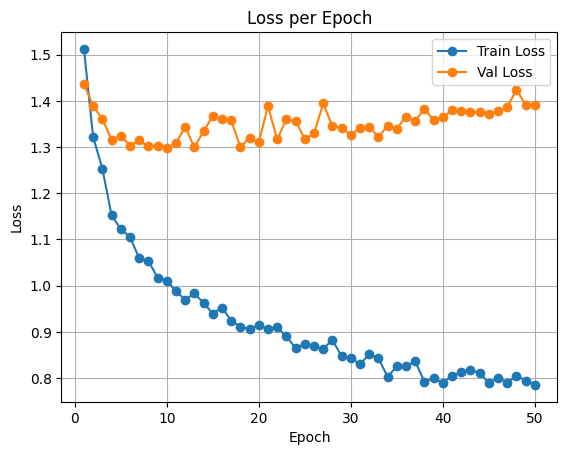

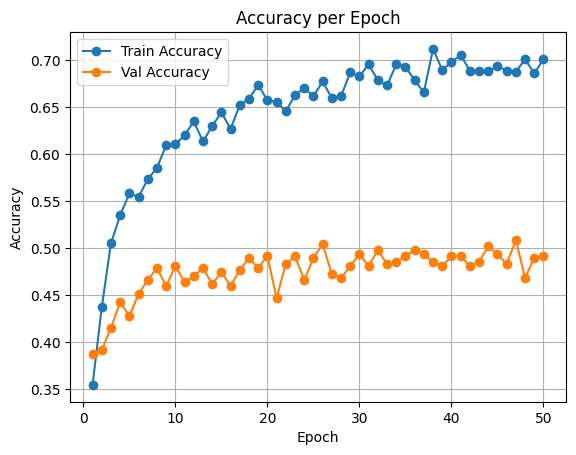

In [19]:
plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

In [20]:
test_metrics = evaluate(model, test_loader, criterion, prefix='test_')

test_Loss: 1.8884, test_Accuracy: 0.3178, test_Precision: 0.2662, test_Recall: 0.2562, test_F1: 0.2039
